In my [last post](/2019/06/multi-class-classification-with-logistic-regression-in-python/), we learned what Logistic Regression is, and how it can be used to classify flowers in the Iris Dataset. In this post we will see how Logistic Regression can be applied to social networks in order to predict future collaboration between researchers. As usual we'll start by importing a few libraries:

In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random, itertools, json
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 200

## Data

The [Microsoft Academic Graph](https://www.microsoft.com/en-us/research/project/microsoft-academic-graph/) (MAG) is a dataset of over 200 million papers. The dataset contains papers from thousands of conferences, journals, and institutions. The [Open Academic Society](https://www.openacademic.ai/) provides regular snapshots of the dataset on their website. For the purpose of this post, I will be using the first one million papers found in [`mag_papers_0.zip`](https://academicgraphv2.blob.core.windows.net/oag/mag/paper/mag_papers_0.zip). Let's take a look at the data:

In [7]:
df = next(pd.read_json('mag_papers_0.txt', lines=True, chunksize=1_000_000))

In [8]:
df = df.dropna(subset=['year', 'authors'])
df.head(n=3).transpose()

,0,1,2
authors,"[{'name': 'Ronald P. Mason', 'id': '2105522006...","[{'name': '侯晓亮', 'id': '2400277081'}]","[{'name': '张冬梅', 'id': '2405201566'}]"
doc_type,Journal,,
doi,10.1007/978-1-4684-5568-7_3,NaN,NaN
id,100000002,1000000047,1000000056
issue,,6,5
n_citation,7,0,0
page_end,27,143,46
page_start,21,143,46
publisher,"Springer, Boston, MA",,
title,Electron Spin Resonance Investigations of Oxyg...,建筑物地基沉降的灰色模型GM（1，1）预测法,“民情日记”消除干群“空心层”


We can see that, in addition to a bunch of other data, each paper has a list of `authors`, each with a unique id, and a `year` that the paper was published. Let's take a look at the histogram of years in our data:

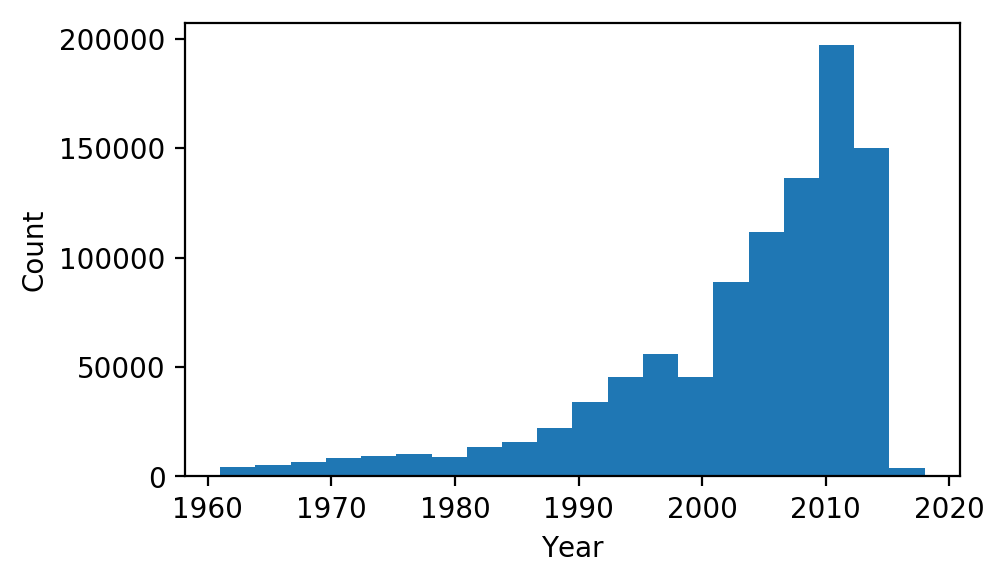

In [27]:
plt.hist(df[df['year'] > 1960]['year'], bins=20)
plt.xlabel('Year'); plt.ylabel('Count');

In order to create our model, we are going to form network graphs from the above data. Each `author` `id` will have its own node, and will share edges with any other author they have co-authored a paper with. We will split the data into three consecutive time frames: $T_0$, $T_1$ and $T_2$. The reason for splitting the data into time frames is so we can train a model to predict if any two authors that have not worked together in $T_n$ will become co-authors in $T _{n+1}$, using only information from $T_n$. Co-author pairs formed from $T_0$ to $T_1$ will be used to train the model, and co-author pairs formed from $T_1$ to $T_2$ will be used as the out-of-sample test set. As many of the papers in the data set have been published between 2000 and 2015, we will use $[2000, 2005)$, $[2005, 2010)$, and $[2010, 2015)$ as $T_0$, $T_1$ and $T_2$, respectively:

In [10]:
time_ranges = [(2000, 2005), (2005, 2010), (2010, 2015)]

We'll write a function to generate the network graphs from our data frame and time ranges:

In [11]:
def data_to_graphs(df, time_ranges):
    graphs = [nx.Graph() for _ in time_ranges]
    for row in df.itertuples():
        for t, time_range in enumerate(time_ranges):
            if row.year >= time_range[0] and row.year < time_range[1]:
                ids = [a['id'] for a in row.authors]
                graphs[t].add_edges_from(itertools.combinations(ids, 2))
    return graphs

In [12]:
graphs = data_to_graphs(df, time_ranges)

Just to take a look at what we have so far, we can draw the largest subcomponent of the first graph like so:

/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


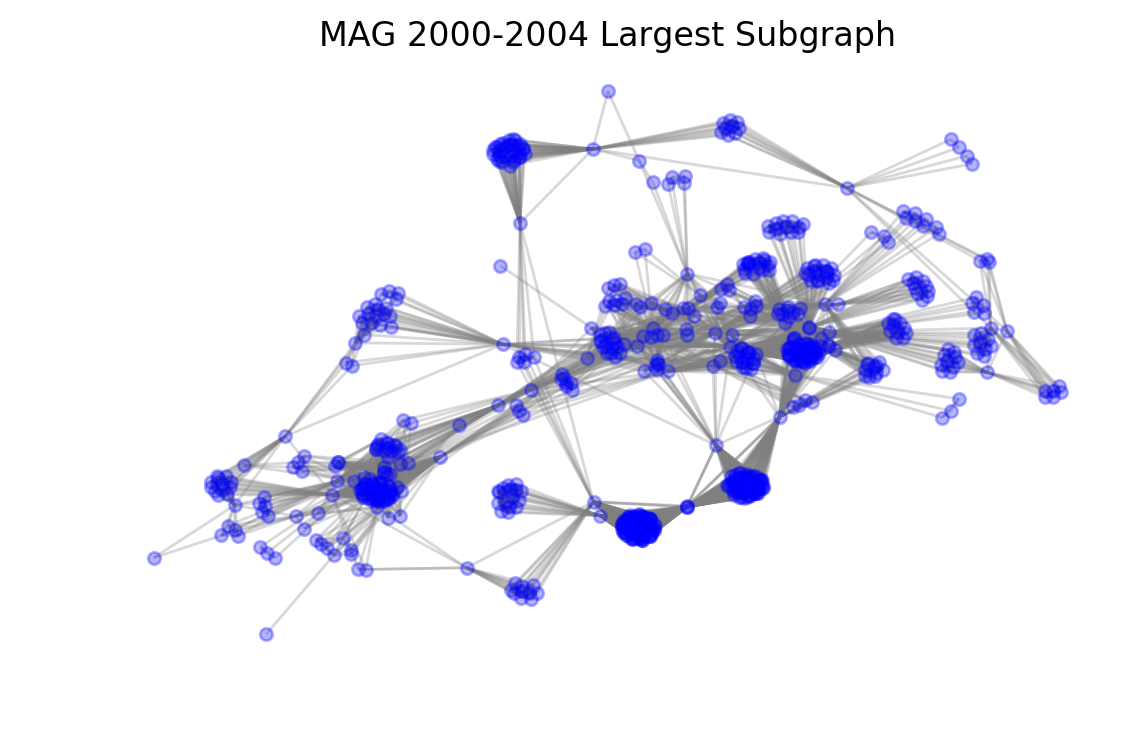

In [52]:
gc = max(nx.connected_component_subgraphs(graphs[0]), key=len)
nx.draw_spring(gc, node_size=20, alpha=0.3, node_color='b', edge_color='grey')
plt.title("MAG 2000-2004 Largest Subgraph");

It is easy to see the clusters formed by large groups of authors that have worked together. We can also see more distant nodes that only have very few connections.

## Labeling

Now that we have our network graphs, we can start creating our training and test sets. Each row in the sets will represent a pair of nodes that have not collaborated. The row will be assigned a positive label if the pair ends up collaborating in the next time period, and a negative label if they don't. Intuitively, there will be a much greater number of pairs with negative labels than positive, so we will randomly select a smaller subset of negative labels (equal to the number of positive labels found). We'll write two functions that help us extract positively and negatively labeled pairs:

In [14]:
def positive_pairs(graph, next_graph):
    pairs = set()
    for pair in next_graph.edges:
        if (
            graph.has_node(pair[0])
            and graph.has_node(pair[1])
            and not graph.has_edge(*pair)
        ):
            pairs.add(pair)
    return pairs

def negative_pairs(graph, next_graph, n):
    pairs = set()
    while len(pairs) < n:
        pair = tuple(random.sample(graph.nodes, 2))
        if (
            not graph.has_edge(*pair)
            and not next_graph.has_edge(*pair)
        ):
            pairs.add(pair)
    return pairs

## Features

Now that we know how our training and test sets will be labeled, we have to decide what other features we want each row of the sets to contain; that is, what indicators may we add that could help our model predict future collaboration? We will pick a few algorithms commonly used in social network analysis:

### Common Neighbors

Our first feature will simply be the number of neighbors that a given pair of nodes share. This can be represented mathematically like so:

$$ | N(u) \cap N(v) | $$

Where $u$ and $v$ are both nodes, and $N(v)$ denotes the set the of all neighbors of node $v$. Common Neighbors was chosen as a feature under the assumption that two authors that share a large number of co-authors may have a higher chance of working together in the future.

### Jaccard Coefficient

The [Jaccard Coefficient](https://en.wikipedia.org/wiki/Jaccard_index) measures similarity between two sets by dividing the size of the intersection by the size of the union. We will compute the Jaccard Coefficient of the neighbors of the two authors like so:

$$ {| N(u) \cap N(v) |}  \over {| N(u) \cup N(v) | }$$

Two nodes that have a high Jaccard Coefficient have very similar neighbors, which might be a good indication for future collaboration.

### Resource Allocation Algorithm

Introduced in 2009 by Tao Zhou, Linyuan Lu, and Yi-Cheng Zhang in [Predicting Missing Links via Local Information](https://arxiv.org/pdf/0901.0553.pdf), the Resource Allocation algorithm is defined as:

$$ \sum_{w \in N(u) \cap N(v)} {1 \over |N(w)|}$$

The idea behind the resource allocation algorithm is that if many of the common neighbors between $u$ and $v$ have a low number of neighbors themselves, any "resources" sent from $u$ have a high likelihood of making their way to $v$ and vice versa.

### Preferential Attachment

Preferential Attachment is simply the product of the size of each node's neighbor set:

$$ |N(u)||N(v)| $$

Two nodes that both have high numbers of neighbors, regardless of their commonality, may have a greater chance of collaboration in the future.

## Generating Features

Since the library we are using for network graph computation, [NetworkX](https://networkx.github.io/), has all of the above functions built in, we can generate all of our features for a given pair like so:

In [15]:
def generate_features(graph, pair, label):
    return {
        "common_neighbors": len(list(nx.common_neighbors(graph, pair[0], pair[1]))),
        "jaccard_coefficient": list(nx.jaccard_coefficient(graph, [pair]))[0][2],
        "resource_allocation": list(nx.resource_allocation_index(graph, [pair]))[0][2],
        "preferential_attachment": list(nx.preferential_attachment(graph, [pair]))[0][2],
        "label": label,
    }

Now we have everything we need to create our training and test sets:

In [16]:
def generate_set(graph, next_graph):
    positives = [
        generate_features(graph, pair, 1)
        for pair in positive_pairs(graph, next_graph)
    ]
    negatives = [
        generate_features(graph, pair, 0)
        for pair in negative_pairs(graph, next_graph, len(positives))
    ]
    return pd.DataFrame(positives + negatives)

In [17]:
df_train = generate_set(graphs[0], graphs[1])
df_test = generate_set(graphs[1], graphs[2])

Let's look at the training set:

In [18]:
df_train.head()

,common_neighbors,jaccard_coefficient,label,preferential_attachment,resource_allocation
0,0,0.0,1,266,0.0
1,0,0.0,1,9966,0.0
2,0,0.0,1,121,0.0
3,0,0.0,1,10,0.0
4,0,0.0,1,4,0.0


We can see that, as expected, each row has a label, and all of the features we wanted. Now we're ready to train!

## Logistic Regression Model

We'll start by splitting our datasets into inputs and labels:

In [19]:
X_train, y_train = df_train.drop(columns=["label"]), df_train["label"]
X_test, y_test = df_test.drop(columns=["label"]), df_test["label"]

Just like in the last post, we'll have to normalize the data so it works well with logistic regression:

In [20]:
mean = X_train.mean()
std = X_train.std()

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

Now we could use the logistic regression code I wrote in my [last post](/2019/06/multi-class-classification-with-logistic-regression-in-python/), but the [scikit-learn](https://scikit-learn.org/stable/) library has an implementation that is slightly more efficient, which will be much faster on our large dataset. Here is how we can use it to fit a model to our training data:

In [21]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train);

Now that we have the model fit, we can check the mean accuracy with our test set:

In [22]:
print(f"Test Accuracy: {model.score(X_test, y_test):.4f}")

Test Accuracy: 0.9370


## Area Under the Curve

Although the model seems to have an almost 94% accuracy in the test set, accuracy is not best metric to use. Both our training and test sets are balanced with an equal number of negative and positive samples, which means that a model predicting positive every time would still have an accuracy of 50%. A better measure of performance of a classification model is known as Area Under the Receiver Operating Characteristics, or AUROC.

### Receiver Operating Characteristics

The [Receiver Operating Characteristics](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC) curve is measure of a binary classifier's ability to distinguish classes. The ROC curve drawn by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR), each defined below, at different thresholds.

$$TPR = {TP \over TP + FN}$$

$$FPR = { TN \over TN + FP }$$

Where $TP$, $FN$, $TN$, $FP$ are the number of True Positives, False Negatives, True Negatives, and False Positives respectively.

Measuring the area under the ROC curve gives an indicator of how well the model can separating positive and negative classifications. An Area Under the Curve (AUC) of 1 means the model can correctly predict the classification every time, while an AUC of 0.5 means the model cannot at all distinguish between positive and negative classes. For more on the AUROC curve, be sure to check out this excellent [blog post](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

We can plot our ROC curve using scikit-learn like so:

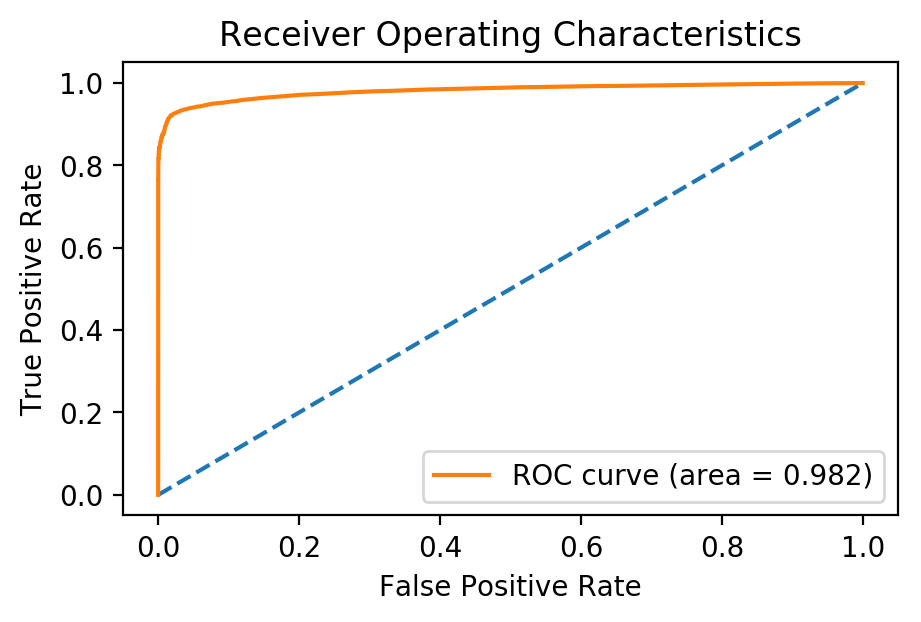

In [53]:
from sklearn.metrics import roc_curve, auc
y_score = model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, label=f"ROC curve (area = {auc(fpr, tpr):.3f})")
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics'); plt.legend();

## Conclusion

By using our trained model on data collected from 2005 to 2009, we were able to predict whether a pair of authors would become co-authors in 2010 to 2014 with an AUC of 0.98! A model like this could be used as an application to suggest researchers to work with in the future. In addition, similar techniques could be used across different social networks to suggest friends on Facebook, or connections on LinkedIn, etc.

There are also a number of ways the above model could be improved. All of the features currently being used are based off of neighbors of nodes formed by co-authorship. More features could be added relating to common paper topics or institutions. In addition, the logistic regression model could be replaced with [support-vector machines](https://en.wikipedia.org/wiki/Support-vector_machine), or a neural network to improve accuracy.

If you liked this article, be sure to follow [@teddykoker](https://twitter.com/teddykoker), and check out my other [machine learning](/tags/machine-learning/) articles.